## CAM, Grad-CAM Iou

**CAM(Class Activation Map)** :  CAM은 Class Activation Map을 뜻하며, 단순화 시켜 이야기 하면 "모델이 어떤 곳을 보고 각 클래스임을 짐작하고 있는지" 확인할 수 있는 지도를 말합니다.  
> CNN 이후 fully connected layer를 사용하는 대신 GAP(Global Average Pooling) 연산을 한 후 이 결과에 소트프맥스 활성화 함수를 적용합니다.  
그 후 마지막 CNN 레이어의 채널 수를 데이터의 클래스 수에 맞추면 각 클래스에 따른 확률을 얻을 수 있게됩니다.     
>   - feature map의 각 채널이 클래스별 신뢰도를 나타내어 해석하기 쉽다.   
>   - fully connected layer과 달리 최적화할 파라미터가 존재하지 않으므로 과적합(overfitting)을 방지할 수 있다.

<br>

**Grad-CAM(Gradient CAM)**  : 기존  **CAM** 모델의 구조에 제한되는 문제를 해결하고 다양한 모델의 구조를 해석할 수 있는 방법을 제안했습니다.    

-  Grad-CAM을 사용하면 CNN 기반의 네트워크는 굳이 **1) 모델 구조를 변경할 필요가 없으며**, 분류 문제 외의 **2) 다른 태스크들에 유연하게 대처**할 수 있습니다.



> **Grad-CAM**이 말하는 CAM의 문제
> 1) 활성화 맵을 얻기 위해서 GAP을 사용하여 $f_k$를 구하고, 그 뒤로 fully connected layer $w^c_k$를 추가로 붙여야한다.    
> 2) 가장 마지막 CNN 레이어의 결과물만을 시각화할 수 있다.   




---

### 0.1 데이터셋 준비  

**Grad-CAM**은 모델의 구조에 대한 제약이 없기에 CAM에 모델을 맞추면 됩니다.   

기본적으로 **CAM** 모델은 **분류(classfication)**를 수행하는 모델이어야 합니다. 하지만 최종 목표는 이미지 내에서 클래스가 활성화 된 위치를 확인하고 이를 정답과 비교하는 것이므로 위치 정보가 기록된 데이터가 함께 있어야 합니다.    

**`Tensorflow Datasets`**의 **`Cars196`** 데이터셋을 사용하겠습니다. 이는 196종의 자동차 종류를 사진으로 판별하는 분류 문제 데이터셋으로, 라벨이 위치정보인 **바운딩 박스(bounding box)** 정보를 포함하고 있습니다. 


- [**Cars196 in Tensorflow Datasets**](https://www.tensorflow.org/datasets/catalog/cars196)

In [1]:
# 커널 재시작 이후 실습을 위해, 이전 스텝의 코드를 모아서 한꺼번에 실행합니다.
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'cars196',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

데이터셋 정보 확인

In [2]:
ds_info

tfds.core.DatasetInfo(
    name='cars196',
    full_name='cars196/2.0.0',
    description="""
    The Cars dataset contains 16,185 images of 196 classes of cars. The data is split into 8,144 training images and 8,041 testing images, where each class has been split roughly in a 50-50 split. Classes are typically at the level of Make, Model, Year, e.g. 2012 Tesla Model S or 2012 BMW M3 coupe.
    """,
    homepage='https://ai.stanford.edu/~jkrause/cars/car_dataset.html',
    data_path='/home/ssac27/tensorflow_datasets/cars196/2.0.0',
    download_size=1.82 GiB,
    dataset_size=1.85 GiB,
    features=FeaturesDict({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=196),
    }),
    supervised_keys=('image', 'label'),
    splits={
        'test': <SplitInfo num_examples=8041, num_shards=8>,
        'train': <SplitInfo num_examples=8144, num_shards=8>,
 

#### 데이터셋 확인
**tfds.show_examples()** 를 통해서 각 이미지의 클래스와 그 인덱스(index)를 확인할 수 있습니다.

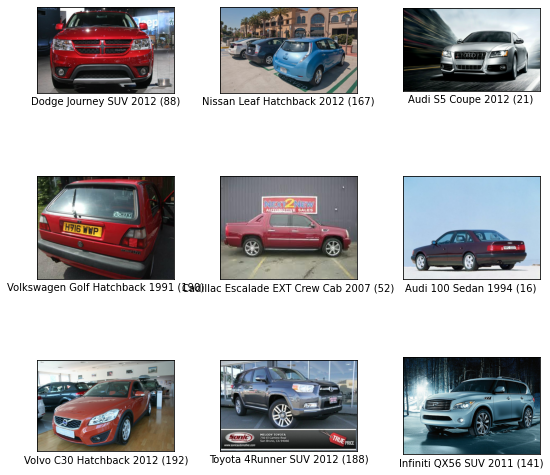

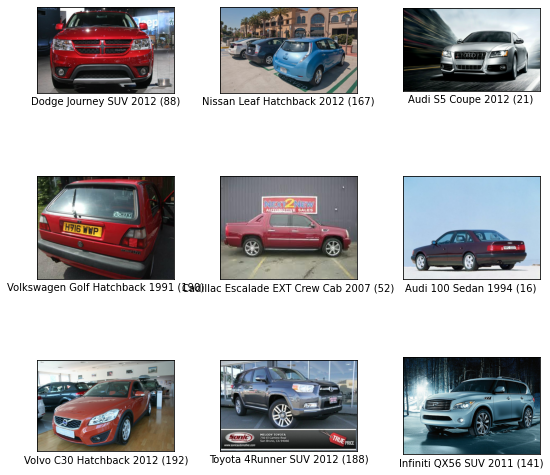

In [3]:
tfds.show_examples(ds_train, ds_info)

---

### 0.2 모델 만들기   
CAM 모델을 이미지넷(imagenet)에 pretrained된 ResNet50을 기반으로 활용하고, 이후 pooling layer 뒤에 소프트맥스 레이어를 붙여 Grad-CAM 모델을 만들겠습니다.


In [4]:
num_classes = ds_info.features["label"].num_classes  # 맞추어야 하는 label들

base_model = keras.applications.resnet.ResNet50(
    include_top=False,    # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224, 3), 
    pooling='avg'   # GAP 적용 
)

x = base_model.output

preds = keras.layers.Dense(
    num_classes,
    activation='softmax'
#    name='fully connected'+num_classes
)(x)

cam_model=keras.Model(inputs=base_model.input, outputs=preds)


In [5]:
# conv5_block3_out
# Global Average Pooling 하기전의 feature mapping 되는 레이어
print(cam_model.layers[-3].output)


Tensor("conv5_block3_out/Relu:0", shape=(None, 7, 7, 2048), dtype=float32)


### CAM 모델 학습하기


학습 데이터와 검증 데이터에 normalizing과 resizing을 포함한 간단한 전처리를 **`normalize_and_resize_img()`** 에서 수행하며, 이를 포함하여 **`apply_normalize_on_dataset()`**에서 배치를 구성합니다.   

**`input`**에 이전과 다르게 **`bbox`** 정보가 포함되어있지만, 지금 수행해야 할 CAM 모델의 학습에는 필요가 없으므로 **`normalize_and_resize_img`** 과정에서 제외해 주었습니다.  
CAM 모델은 object detection이나 segmentation에도 활용될 수 있지만, bounding box같은 직접적인 라벨을 사용하지 않고 weakly supervised learning을 통해 물체 영역을 간접적으로 학습시키는 방식이기 때문입니다.

In [6]:
def normalize_and_resize_img(input):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [7]:
# 데이터셋에 전처리와 배치처리를 적용합니다. 
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


이제 모델을 컴파일하고 학습시킵시다.   

In [8]:
tf.random.set_seed(2021)
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [9]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=15,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
509/509 [==============================] - 81s 159ms/step - loss: 4.2337 - accuracy: 0.1577 - val_loss: 5.4421 - val_accuracy: 0.0061
Epoch 2/15
509/509 [==============================] - 95s 187ms/step - loss: 1.7008 - accuracy: 0.6345 - val_loss: 2.0130 - val_accuracy: 0.4930
Epoch 3/15
509/509 [==============================] - 81s 159ms/step - loss: 0.5780 - accuracy: 0.8992 - val_loss: 1.2725 - val_accuracy: 0.6650
Epoch 4/15
509/509 [==============================] - 81s 159ms/step - loss: 0.1826 - accuracy: 0.9832 - val_loss: 1.1346 - val_accuracy: 0.6983
Epoch 5/15
509/509 [==============================] - 81s 159ms/step - loss: 0.0711 - accuracy: 0.9957 - val_loss: 1.0524 - val_accuracy: 0.7175
Epoch 6/15
509/509 [==============================] - 81s 159ms/step - loss: 0.0299 - accuracy: 0.9991 - val_loss: 1.0195 - val_accuracy: 0.7244
Epoch 7/15
509/509 [==============================] - 81s 160ms/step - loss: 0.0189 - accuracy: 0.9996 - val_loss: 1.0189 - val_ac

학습시킨 가중치를 저장해 주겠습니다.

In [10]:
import os

cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model.h5'
cam_model.save(cam_model_path)

---

## CAM

>CAM 생성 작업은 데이터셋 배치 단위가 아니라 개별 이미지 데이터 단위로 이루어지기 때문에, **`get_one()`** 함수로 데이터셋에서 한 장씩 뽑을 수 있도록 했습니다.

In [2]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

145


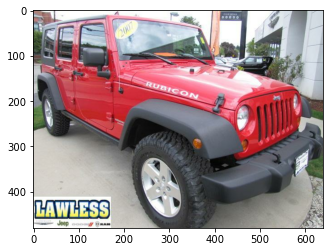

In [3]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

In [4]:
import os

# 사전에 학습한 모델 불러오기
cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

## CAM 구현하기
---

### 1) CAM을 구현해 봅시다. 

CAM을 생성하기 위해서는 **(1) 특성 맵, (2) 클래스 별 확률을 얻기 위한 소프트맥스 레이어의 가중치, 그리고 (3) 원하는 클래스의 출력값**이 필요합니다. 또 이미지에서 모델이 어떤 부분을 보는지 직관적으로 확인하려면 네트워크에서 나온 CAM을 입력 이미지 사이즈와 같게 만들어 함께 시각화 해야 할 것입니다. 이를 고려해서 **`model`**과 **`item`**을 받았을 때 입력 이미지와 동일한 크기의 CAM을 반환하는 함수를 만들어야 합니다.

**`generate_cam()`** 을 구현하기 위해 아래에서는 **conv_outputs**와 같이 특정 레이어의 결과값을 output으로 받기 위해 새로운 모델을 정의하고, feedforward를 거친 후 CAM을 계산하도록 구현하였습니다. 마지막에는 입력 이미지의 크기에 맞춰 CAM을 **resize** 해주었습니다.

In [5]:
def generate_cam(model, item):
    # image shape -> y,x, channel
    item = copy.deepcopy(item)
    height, width = item['image'].shape[:2]

    # (1) feature map 얻기
    img_tensor, class_label =  normalize_and_resize_img(item)  # item 정규화
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    # Activation -> GAP  -> Dense  [모델의 마지막 output 과정]   :   [-3]   [-2]    [-1]
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, axis=0))
    
    # (2) 클래스 별 확률을 얻기 위한 소프트맥스 레이어의 가중치
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] #마지막 모델의 weight activation을 가져옵니다.

    
    # TODO: generate cam image
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[:2])
    for i, w in enumerate(class_weights[:, class_label]) :
        # W * f 를 통해 class별 activation map을 계산합니다.
        cam_image += w * conv_outputs[:, :, i]
    
     # activation score를 normalize한다.
    cam_image /= np.max(cam_image)
    cam_image = cam_image.numpy()   # numpy 타입으로 변환
    cam_image = cv2.resize(cam_image, (width, height)) # 원래의 이미지 크기로 resize 합니다.
    return cam_image

이제 위에서 작성한 함수를 실행하면 아래와 같은 CAM을 얻을 수 있습니다. 생각보다 위치를 정확하게 표현하고 있습니다.

### 2) generate_cam함수로 CAM 이미지를 생성


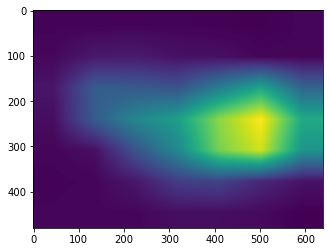

In [6]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)


3) 원본 이미지와 CAM 이미지를 입력으로 받고 두 개의 이미지의 투명도를 조정, 하나의 이미지에서 원본과 CAM을 겹쳐 보여주는 **`visualize_cam_on_image()`** 함수를 만들어봅시다.

- 참고: [webnautes님의 OpenCV Python 강좌 - 두 개의 이미지 더하기, 블렌딩](https://webnautes.tistory.com/1245)

In [7]:
def visualize_cam_on_image(image, cam_image, alpha=0.5):
    #  blend image
    beta = (1.0-alpha)
    merged_image = cv2.addWeighted(image, alpha, cam_image, beta, 0.0)
    return merged_image

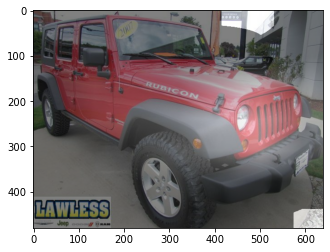

In [8]:
# visualize_cam_on_image() 함수 사용

type(item['image'])

origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)

In [9]:
type(item['image'])

numpy.ndarray

---
## Grad-CAM 구현하기


### 1) Grad-CAM 구현

 Grad-CAM을 이용해서 CAM을 얻어보도록 하겠습니다. 적용 모델을 유연하게 선택할 수 있는 Grad-CAM의 특성 상 위에서 만들었던 모델을 다시 활용해도 괜찮기 때문에 관찰 대상 모델은 **cam_model**을 그대로 활용해 봅니다.  

**`grad_cam`**은 관찰을 원하는 레이어와 정답 클래스에 대한 예측값 사이의 그래디언트를 구하고, 여기에 GAP 연산을 적용함으로써 관찰 대상이 되는 레이어의 채널별 가중치를 구합니다. 최종 CAM 이미지를 구하기 위해서는 레이어의 채널별 가중치(**`weights`**)와 레이어에서 나온 채널별 특성 맵을 가중합 해주어 **cam_image**를 얻습니다.   

Grad-CAM은 어떤 레이어든 CAM 이미지를 뽑아낼 수 있으므로, 그래디언트 계산을 원하는 관찰 대상 레이어 **`activation_layer`**를 뽑아서 쓸 수 있도록 **`activation_layer`**의 이름을 받고 이를 활용해야 합니다.   

122


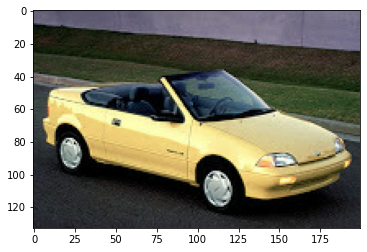

In [10]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

**generate_grad_cam** 원하는 레이어의 **output**과 특정 클래스의 **prediction** 사이의 그래디언트 **grad_val**을 얻고 이를 **weights**로 활용

In [11]:
def generate_grad_cam(model, activation_layer, item):
    # generate grad_cam_image
    # 1) image normalize
    item = copy.deepcopy(item)   # itme 원본 객체를 다룰 수 있으므로  깊은 복사를 해주어 방지 한다.  
    height, width = item['image'].shape[0:2]
    img_tensor, class_label = normalize_and_resize_img(item)
    
    #  특정 레이어의 output을 필요로 하므로 해당 레이어의 이름으로 찾은 후 output으로 추가 
    grad_model = tf.keras.Model([model.inputs] , [model.get_layer(activation_layer).output, model.output]   )
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, axis=0))
        
        loss = pred[:, class_label]  # 원하는 class의 예측값을 얻습니다.  [지금은 정답으로 활용]
        output = conv_output[0]      # 원하는 layer의 output을 얻습니다.   conv_output.shape -> [1,x,x,x]
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.
        
    weights = np.mean(grad_val, axis=(0, 1))  # gradient_val를 전체에 대하여 np.mean -> GAP이다.
                                              # class별 weights를 구합니다.    
    grad_cam_image = np.zeros(shape=conv_output.shape[0:2]  , dtype=np.float32)
    for k,w in enumerate(weights) :
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻습니다.
        grad_cam_image += w * output[:,:,k]
        
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

cam_model의 마지막 엑티베이션 맵 이름인  'conv5_block3_out'을  사용하겠습니다

In [13]:
# activation_layer 이름 찾기 
cam_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

### 2) generate_grad_cam() 함수로 여러 레이어의 CAM 이미지를 뽑아서 직접 확인해 봅시다.

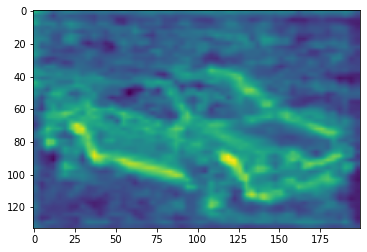

In [14]:
grad_cam_image = generate_grad_cam(cam_model, 'conv2_block3_out', item)
plt.imshow(grad_cam_image)

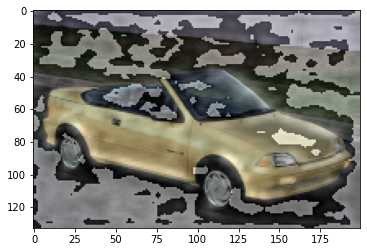

In [15]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)

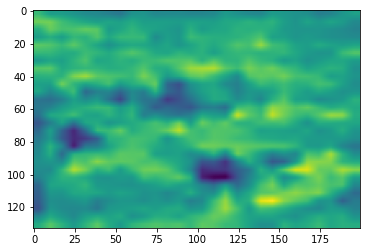

In [16]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)

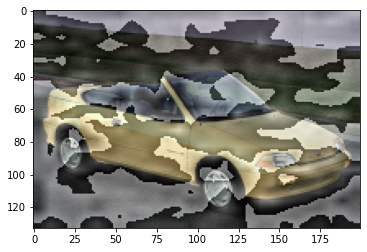

In [17]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)

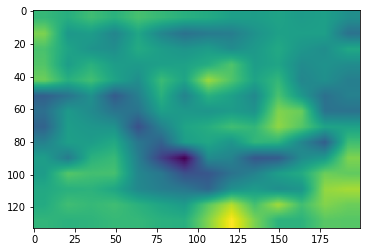

In [18]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)

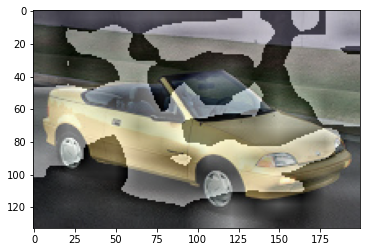

In [19]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)

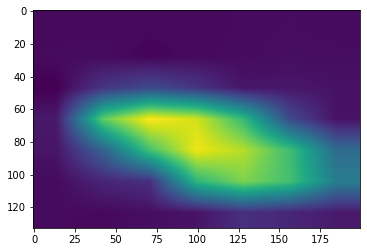

In [20]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)

3) 위에서 만든 이미지 **`visualize_cam_on_image()`** 함수로 이미지를 시각화해 보세요.

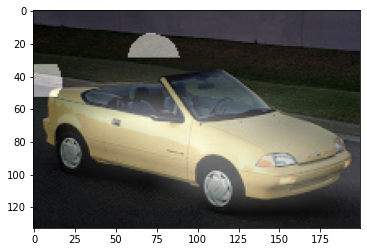

In [21]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)

## 바운딩 박스 구하기
---

<br>

### 1) Grad-CAM으로 얻은 CAM을 통해서 바운딩 박스를 구하기

**get_bbox()** 함수는 바운딩 박스를 만들기 위해서 **score_thresh**를 받아 역치값 이하의 바운딩 박스는 없앱니다. 그 다음 OpenCV의 **findContours()**와 **minAreaRect()**로 사각형을 찾습니다. 이때 **rotated_rect** 라는 회전된 바운딩 박스를 얻을 수 있습니다. **boxPoints()**로 이를 꼭지점으로 바꾸어 줍니다. 마지막에는 **int** 자료형으로 변환해 줍니다.

**findContours** :   
- Suzuki85 알고리즘을 사용하여 이진 영상에서 윤곽선을 검색합니다.   
윤곽 . 모양 분석과 물체 감지 및 인식에 유용한 도구입니다.

**minAreaRect**  :  
- 최소 영역 경계 사각형 (회전 가능)을 계산하고 반환합니다. . 지정된 포인트 세트. 개발자는 반환 된 RotatedRect가 음수를 포함 할 수 있음을 명심해야합니다.

**boxPoints** :  
- 회전된 사각형의 정점(꼭짓점)을 반환합니다.

findContours로 cam의 윤곽 부분을 잡고 image를 반환하며, 반환된 image에서 최소 영역 경계 사각형을 반환합니다.

122


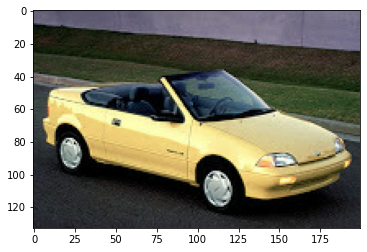

In [22]:
print(item['label'])
plt.imshow(item['image'])

#### CAM image

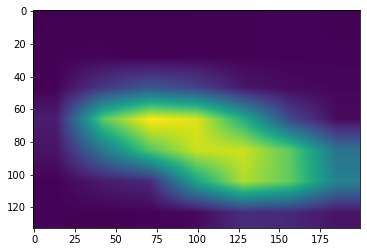

In [23]:
# cam_image
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

#### Grad CAM image

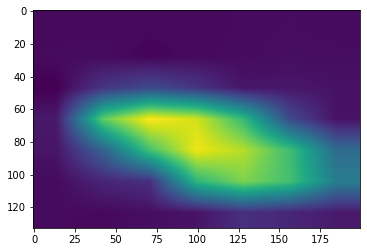

In [24]:
# Grad_cam image
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)

In [26]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]

    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect) 
    rect = np.int0(rect)
    return rect

### 2) 바운딩 박스 시각화

#### Cam image

In [28]:
# CAM bounding box
cam_rect = get_bbox(cam_image)
cam_rect

array([[-11,  94],
       [ 17,   4],
       [216,  67],
       [187, 157]])

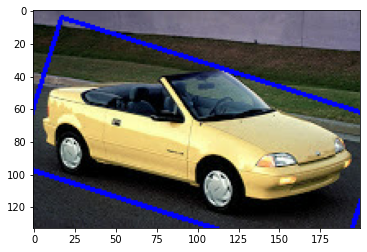

In [29]:
image = copy.deepcopy(item['image'])
cam_image = cv2.drawContours(image,[cam_rect],0,(0,0,255),2)
plt.imshow(cam_image)

#### Grad_Cam image

In [30]:
# Grad-CAM bounding box
grad_cam_rect = get_bbox(grad_cam_image)
grad_cam_rect

array([[  4, 108],
       [ 25,  17],
       [213,  61],
       [192, 151]])

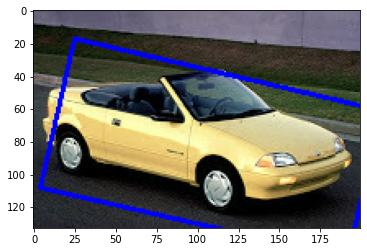

In [31]:
image = copy.deepcopy(item['image'])
grad_cam_image = cv2.drawContours(image,[grad_cam_rect],0,(0,0,255),2)
plt.imshow(grad_cam_image)

Grad_cam과 CAM image에 bounding_box가 그려진것을 확인할 수 있습니다.   

## IoU 구하기
---
**1) 정답 바운딩 박스(ground truth)**와 **예측값 바운딩 박스(prediction box)** 두 가지를 이용해서 IoU를 계산하겠습니다.  

In [32]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
# bounding_box의 image.shape는 (y, x)의 형태이다.
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

#### CAM 예측값 바운딩 박스(prediction box)

In [33]:
cam_rect

array([[-11,  94],
       [ 17,   4],
       [216,  67],
       [187, 157]])

In [34]:
# CAM  예측값 바운딩 박스 ( prediction box )
cam_pred_bbox = rect_to_minmax(cam_rect, item['image'])
cam_pred_bbox

[0.03007518796992481, -0.055, 1.1804511278195489, 1.08]

#### Grad-CAM 예측값 바운딩 박스(prediction box)

In [35]:
grad_cam_rect

array([[  4, 108],
       [ 25,  17],
       [213,  61],
       [192, 151]])

In [36]:
# Grad-cam 예측값 바운딩 박스 ( Prediction box )
grad_cam_pred_bbox = rect_to_minmax(grad_cam_rect, item['image'])
grad_cam_pred_bbox

[0.12781954887218044, 0.02, 1.1353383458646618, 1.065]

####  ground truth bbox

In [74]:
item['bbox']

array([0.24812031, 0.03      , 0.9398496 , 0.985     ], dtype=float32)

In [45]:
def get_iou(get_bbox, pred_bbox):
    iou = None
    # get iou between two bbox
    y_min = max(get_bbox[0],pred_bbox[0])
    x_min = max(get_bbox[1],pred_bbox[1])
    y_max = min(get_bbox[2],pred_bbox[2])
    x_max = min(get_bbox[3],pred_bbox[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    get_bboxArea = (get_bbox[2] - get_bbox[0]) *  (get_bbox[3] - get_bbox[1])
    pred_bboxArea = (pred_bbox[2] - pred_bbox[0]) *  (pred_bbox[3] - pred_bbox[1])
    
    iou = interArea / float(get_bboxArea+ pred_bboxArea - interArea)
    
    return iou

### 2) CAM과 Grad-CAM으로 얻은 바운딩 박스와 정답 바운딩 박스와의 IoU를 각각 비교해 봅시다.

#### Grad-CAM pred Iou

In [46]:
get_iou(item['bbox'],  grad_cam_pred_bbox )

0.6274369710821309

#### CAM pred Iou

In [47]:
get_iou(item['bbox'],  cam_pred_bbox )

0.5059456915184176

Grad-CAM의  Iou가 더 높게 나왔습니다.

그림으로 봤을때는 CAM image의 bounding box가 더 올바르게 보이지만,  item['bbox'] 값을 잘 보면 좁은 범위로 차에 bounding box를 그리고 있는것을 알 수 있습니다.   

---

## 회고

- 이미지 분류를 공부 할 때 CAM이라는 용어에 대해서만 듣고 제대로 시도는 못해봤는데 이번에 할 수 있게되어서 다행인것 같습니다.   


- 기존의 이미지 분류를 할 때 모델이 깊어질 수록 주요한 feature가 강조되는 것만 알고 있었지, 실제로 모델에서 어느 부분이 주요한 feature로 output 되는지는 모르고 있었습니다.   
그렇지만, 이번에 CAM을 하면서 모델이 생각하는 주요한 feature의 output만 알고 싶으면 CAM, 마지막 feature뿐만 아니라 전체적인 layer를 보고 싶다면 Grad-CAM을 적용할 수 있을것 같습니다.    


- CAM을 해보면서 이 기술이 중요하게 여겨질 분야에 대해 생각을 해봤습니다.   
자율주행 차, 인공위성에서의 사물 인식 등을 생각해 봤지만 아무래도 의료 분야에서 가장 중요하게 다뤄질것 같습니다.    
CAM은 결국 모델에 대한 결과가 신뢰를 할 수 있는가에 대한 것이기 때문에, 여러 분야중 모델이 왜 그런 결정을 내렸는지 반드시 알아야하는 분야는 의료 분야라고 생각이 됩니다.    
의료다보니 약간의 실수에도 큰 피해가 나올 수 있기에 의료 분야에서의 CAM이 중요하게 여겨질것 같습니다.